Now that we have selected our final model. Let's evaluate the performance on un-seen data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle
# load the model
best_model = pickle.load(open('best_classifier.pkl','rb'))


In [3]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def fill_my_missing(df, df_mean_in):
    # This function fills the missing values

    for c in col2use:
        mean_value = df_mean_in.loc[df_mean_in.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

# Prepare the data

In [4]:
df_train = pd.read_csv('df_train.csv')
df_valid= pd.read_csv('df_valid.csv')
df_test= pd.read_csv('df_test.csv')

In [5]:
col2use = [c for c in list(df_train.columns) if c != 'OUTPUT_LABEL']
print('Number of columns to use:', len(col2use))

Number of columns to use: 143


In [6]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])

# fill missing
df_train = fill_my_missing(df_train, df_mean_in)
df_valid = fill_my_missing(df_valid, df_mean_in)
df_test = fill_my_missing(df_test, df_mean_in)

# create X and y matrices
X_train = df_train[col2use].values
X_valid = df_valid[col2use].values
X_test = df_test[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values
y_test = df_test['OUTPUT_LABEL'].values

# load the scaler
scaler = pickle.load(open('scaler.sav', 'rb'))

# transform our data matrices 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

C:\Program Files\Anaconda3\envs\pa_2018\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Predictions

In [7]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]


# Evaluate the performance

In [8]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.677
accuracy:0.623
recall:0.550
precision:0.645
specificity:0.697
prevalence:0.500
 
Validation:
AUC:0.664
accuracy:0.666
recall:0.551
precision:0.180
specificity:0.680
prevalence:0.113
 
Test:
AUC:0.660
accuracy:0.660
recall:0.557
precision:0.185
specificity:0.674
prevalence:0.117
 


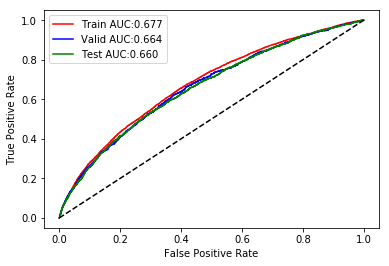

In [9]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Nice job! Your test set matches your validation set and your training set is not overfitting! 